# Using text similarity for automatic category mapping

Given a set of category labels (e.g. from a computer system or referential) and another set of category labels (e.g. from another computer system or referential),

try to infer an automatic mapping from each source category to a destination category.

Assuming the two sets of categories roughly correspond to the same business domain, use text similarity to compare the internal representations of each category and map similar categories together.


## Install Spacy

Use [Spacy](https://spacy.io/usage/linguistic-features#vectors-similarity) module to compute text similarity.

> reference: http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/text_sentiment_wordvec.html

In [ ]:
import sys
!{sys.executable} -m pip install -U setuptools wheel
!{sys.executable} -m pip install -U spacy

Download pre-trained data for French

In [ ]:
import sys
!{sys.executable} -m spacy download fr_core_news_lg


Download pre-trained data for English

In [16]:
# import sys
# !{sys.executable} -m spacy download en_core_web_lg

Prepare NLP classifiers from Spacy module

In [8]:
import spacy
# nlp_en = spacy.load("en_core_web_lg")
nlp_fr = spacy.load("fr_core_news_lg")

## Data preparation

Use nltk and unidecode modules to pre-process data:
- remove stop words
- lemmatization
- remove unicode characters
- etc.

> reference: https://intellica-ai.medium.com/comparison-of-different-word-embeddings-on-text-similarity-a-use-case-in-nlp-e83e08469c1c

In [ ]:
import sys
!{sys.executable} -m pip install nltk unidecode

Download nltk datasets

In [ ]:
!{sys.executable} -m nltk.downloader all

Pre-processing

In [2]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from unidecode import unidecode
import string

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()

def pre_process(corpus, language):
    # convert input corpus to lower case.
    corpus = corpus.lower()

    corpus = remove_gender_suffixes(corpus)

    # collecting a list of stop words from nltk and punctuation form
    # string class and create single array.
    stopset = stopwords.words(language) + list(string.punctuation)
    # remove stop words and punctuations from string.
    # word_tokenize is used to tokenize the input corpus in word tokens.
    corpus = " ".join([i for i in word_tokenize(corpus) if i not in stopset])

    corpus = " ".join([lemmatizer.lemmatize(w) for w in word_tokenize(corpus)])

    # remove non-ascii characters
    corpus = unidecode(corpus)
    return corpus

gender_suffixes = ["(trice)","(e)","(ère)","(se)"]

def remove_gender_suffixes(corpus):
    for s in gender_suffixes:
        corpus = corpus.replace(s, "")
    return corpus



## Source and destination categories

In [3]:
insee = [
    "Agriculteurs",
    "Artisans",
    "Commerçants et assimilés",
    "Chefs d'entreprise de plus de 10 personnes",
    "Professions libérales",
    "Cadres de la fonction publique",
    "Professeurs et professions scientifiques",
    "Professions de l'information, de l'art et des spectacles",
    "Cadres administratifs et commerciaux",
    "Cadres techniques d'entreprise",
    "Professions de l'enseignement primaire et professionnel",
    "Intermédiaires de la santé et du travail social",
    "Religieux",
    "Intermédiaires de la fonction publique",
    "Intermédiaires des entreprises",
    "Techniciens",
    "Agents de maîtrise de production",
    "Employés de la fonction publique",
    "Policiers, militaires et agents de sécurité privée",
    "Employés administratifs d'entreprise",
    "Employés de commerce",
    "Personnels des services aux particuliers",
    "Ouvriers qualifiés de type industriel",
    "Ouvriers qualifiés de type artisanal",
    "Conducteurs du transport",
    "Conducteurs d'engins et magasiniers",
    "Ouvriers peu qualifiés de type industriel",
    "Ouvriers peu qualifiés de type artisanal",
    "Ouvriers agricoles",
]

naf = [
    "Cultures non permanentes",
    "Cultures permanentes",
    "Reproduction de plantes",
    "Production animale",
    "Culture et élevage associés",
    "Activités de soutien à l'agriculture et traitement primaire des récoltes",
    "Chasse, piégeage et services annexes",
    "Sylviculture et autres activités forestières",
    "Exploitation forestière",
    "Récolte de produits forestiers non ligneux poussant à l'état sauvage",
    "Services de soutien à l'exploitation forestière",
    "Pêche",
    "Aquaculture",
    "Extraction de houille",
    "Extraction de lignite",
    "Extraction de pétrole brut",
    "Extraction de gaz naturel",
    "Extraction de minerais de fer",
    "Extraction de minerais de métaux non ferreux",
    "Extraction de pierres, de sables et d'argiles",
    "Activités extractives n.c.a.",
    "Activités de soutien à l'extraction d'hydrocarbures",
    "Activités de soutien aux autres industries extractives",
    "Transformation et conservation de la viande et préparation de produits à base de viande",
    "Transformation et conservation de poisson, de crustacés et de mollusques",
    "Transformation et conservation de fruits et légumes",
    "Fabrication d'huiles et graisses végétales et animales",
    "Fabrication de produits laitiers",
    "Travail des grains ; fabrication de produits amylacés",
    "Fabrication de produits de boulangerie-pâtisserie et de pâtes alimentaires",
    "Fabrication d'autres produits alimentaires",
    "Fabrication d'aliments pour animaux",
    "Fabrication de boissons",
    "Fabrication de produits à base de tabac",
    "Préparation de fibres textiles et filature",
    "Tissage",
    "Ennoblissement textile",
    "Fabrication d'autres textiles",
    "Fabrication de vêtements, autres qu'en fourrure",
    "Fabrication d'articles en fourrure",
    "Fabrication d'articles à mailles",
    "Apprêt et tannage des cuirs ; préparation et teinture des fourrures ; fabrication d'articles de voyage, de maroquinerie et de sellerie",
    "Fabrication de chaussures",
    "Sciage et rabotage du bois",
    "Fabrication d'articles en bois, liège, vannerie et sparterie",
    "Fabrication de pâte à papier, de papier et de carton",
    "Fabrication d'articles en papier ou en carton",
    "Imprimerie et services annexes",
    "Reproduction d'enregistrements",
    "Cokéfaction",
    "Raffinage du pétrole",
    "Fabrication de produits chimiques de base, de produits azotés et d'engrais, de matières plastiques de base et de caoutchouc synthétique",
    "Fabrication de pesticides et d'autres produits agrochimiques",
    "Fabrication de peintures, vernis, encres et mastics",
    "Fabrication de savons, de produits d'entretien et de parfums",
    "Fabrication d'autres produits chimiques",
    "Fabrication de fibres artificielles ou synthétiques",
    "Fabrication de produits pharmaceutiques de base",
    "Fabrication de préparations pharmaceutiques",
    "Fabrication de produits en caoutchouc",
    "Fabrication de produits en plastique",
    "Fabrication de verre et d'articles en verre",
    "Fabrication de produits réfractaires",
    "Fabrication de matériaux de construction en terre cuite",
    "Fabrication d'autres produits en céramique et en porcelaine",
    "Fabrication de ciment, chaux et plâtre",
    "Fabrication d'ouvrages en béton, en ciment ou en plâtre",
    "Taille, façonnage et finissage de pierres",
    "Fabrication de produits abrasifs et de produits minéraux non métalliques n.c.a.",
    "Sidérurgie",
    "Fabrication de tubes, tuyaux, profilés creux et accessoires correspondants en acier",
    "Fabrication d'autres produits de première transformation de l'acier",
    "Production de métaux précieux et d'autres métaux non ferreux",
    "Fonderie",
    "Fabrication d'éléments en métal pour la construction",
    "Fabrication de réservoirs, citernes et conteneurs métalliques",
    "Fabrication de générateurs de vapeur, à l'exception des chaudières pour le chauffage central",
    "Fabrication d'armes et de munitions",
    "Forge, emboutissage, estampage ; métallurgie des poudres",
    "Traitement et revêtement des métaux ; usinage",
    "Fabrication de coutellerie, d'outillage et de quincaillerie",
    "Fabrication d'autres ouvrages en métaux",
    "Fabrication de composants et cartes électroniques",
    "Fabrication d'ordinateurs et d'équipements périphériques",
    "Fabrication d'équipements de communication",
    "Fabrication de produits électroniques grand public",
    "Fabrication d'instruments et d'appareils de mesure, d'essai et de navigation ; horlogerie",
    "Fabrication d'équipements d'irradiation médicale, d'équipements électromédicaux et électrothérapeutiques",
    "Fabrication de matériels optique et photographique",
    "Fabrication de supports magnétiques et optiques",
    "Fabrication de moteurs, génératrices et transformateurs électriques et de matériel de distribution et de commande électrique",
    "Fabrication de piles et d'accumulateurs électriques",
    "Fabrication de fils et câbles et de matériel d'installation électrique",
    "Fabrication d'appareils d'éclairage électrique",
    "Fabrication d'appareils ménagers",
    "Fabrication d'autres matériels électriques",
    "Fabrication de machines d'usage général",
    "Fabrication d'autres machines d'usage général",
    "Fabrication de machines agricoles et forestières",
    "Fabrication de machines de formage des métaux et de machines-outils",
    "Fabrication d'autres machines d'usage spécifique",
    "Construction de véhicules automobiles",
    "Fabrication de carrosseries et remorques",
    "Fabrication d'équipements automobiles",
    "Construction navale",
    "Construction de locomotives et d'autre matériel ferroviaire roulant",
    "Construction aéronautique et spatiale",
    "Construction de véhicules militaires de combat",
    "Fabrication de matériels de transport n.c.a.",
    "Fabrication de meubles",
    "Fabrication d'articles de joaillerie, bijouterie et articles similaires",
    "Fabrication d'instruments de musique",
    "Fabrication d'articles de sport",
    "Fabrication de jeux et jouets",
    "Fabrication d'instruments et de fournitures à usage médical et dentaire",
    "Activités manufacturières n.c.a.",
    "Réparation d'ouvrages en métaux, de machines et d'équipements",
    "Installation de machines et d'équipements industriels",
    "Production, transport et distribution d'électricité",
    "Production et distribution de combustibles gazeux",
    "Production et distribution de vapeur et d'air conditionné",
    "Captage, traitement et distribution d'eau",
    "Collecte et traitement des eaux usées",
    "Collecte des déchets",
    "Traitement et élimination des déchets",
    "Récupération",
    "Dépollution et autres services de gestion des déchets",
    "Promotion immobilière",
    "Construction de bâtiments résidentiels et non résidentiels",
    "Construction de routes et de voies ferrées",
    "Construction de réseaux et de lignes",
    "Construction d'autres ouvrages de génie civil",
    "Démolition et préparation des sites",
    "Travaux d'installation électrique, plomberie et autres travaux d'installation",
    "Travaux de finition",
    "Autres travaux de construction spécialisés",
    "Commerce de véhicules automobiles",
    "Entretien et réparation de véhicules automobiles",
    "Commerce d'équipements automobiles",
    "Commerce et réparation de motocycles",
    "Intermédiaires du commerce de gros",
    "Commerce de gros de produits agricoles bruts et d'animaux vivants",
    "Commerce de gros de produits alimentaires, de boissons et de tabac",
    "Commerce de gros de biens domestiques",
    "Commerce de gros d'équipements de l'information et de la communication",
    "Commerce de gros d'autres équipements industriels",
    "Autres commerces de gros spécialisés",
    "Commerce de gros non spécialisé",
    "Commerce de détail en magasin non spécialisé",
    "Commerce de détail alimentaire en magasin spécialisé",
    "Commerce de détail de carburants en magasin spécialisé",
    "Commerce de détail d'équipements de l'information et de la communication en magasin spécialisé",
    "Commerce de détail d'autres équipements du foyer en magasin spécialisé",
    "Commerce de détail de biens culturels et de loisirs en magasin spécialisé",
    "Autres commerces de détail en magasin spécialisé",
    "Commerce de détail sur éventaires et marchés",
    "Commerce de détail hors magasin, éventaires ou marchés",
    "Transport ferroviaire interurbain de voyageurs",
    "Transports ferroviaires de fret",
    "Autres transports terrestres de voyageurs",
    "Transports routiers de fret et services de déménagement",
    "Transports par conduites",
    "Transports maritimes et côtiers de passagers",
    "Transports maritimes et côtiers de fret",
    "Transports fluviaux de passagers",
    "Transports fluviaux de fret",
    "Transports aériens de passagers",
    "Transports aériens de fret et transports spatiaux",
    "Entreposage et stockage",
    "Services auxiliaires des transports",
    "Activités de poste dans le cadre d'une obligation de service universel",
    "Autres activités de poste et de courrier",
    "Hôtels et hébergement similaire",
    "Hébergement touristique et autre hébergement de courte durée",
    "Terrains de camping et parcs pour caravanes ou véhicules de loisirs",
    "Autres hébergements",
    "Restaurants et services de restauration mobile",
    "Traiteurs et autres services de restauration",
    "Débits de boissons",
    "Édition de livres et périodiques et autres activités d'édition",
    "Édition de logiciels",
    "Activités cinématographiques, vidéo et de télévision",
    "Enregistrement sonore et édition musicale",
    "Édition et diffusion de programmes radio",
    "Programmation de télévision et télédiffusion",
    "Télécommunications filaires",
    "Télécommunications sans fil",
    "Télécommunications par satellite",
    "Autres activités de télécommunication",
    "Programmation, conseil et autres activités informatiques",
    "Traitement de données, hébergement et activités connexes ; portails Internet",
    "Autres services d'information",
    "Intermédiation monétaire",
    "Activités des sociétés holding",
    "Fonds de placement et entités financières similaires",
    "Autres activités des services financiers, hors assurance et caisses de retraite",
    "Assurance",
    "Réassurance",
    "Caisses de retraite",
    "Activités auxiliaires de services financiers, hors assurance et caisses de retraite",
    "Activités auxiliaires d'assurance et de caisses de retraite",
    "Gestion de fonds",
    "Activités des marchands de biens immobiliers",
    "Location et exploitation de biens immobiliers propres ou loués",
    "Activités immobilières pour compte de tiers",
    "Activités juridiques",
    "Activités comptables",
    "Activités des sièges sociaux",
    "Conseil de gestion",
    "Activités d'architecture et d'ingénierie",
    "Activités de contrôle et analyses techniques",
    "Recherche-développement en sciences physiques et naturelles",
    "Recherche-développement en sciences humaines et sociales",
    "Publicité",
    "Études de marché et sondages",
    "Activités spécialisées de design",
    "Activités photographiques",
    "Traduction et interprétation",
    "Autres activités spécialisées, scientifiques et techniques n.c.a.",
    "Activités vétérinaires",
    "Location et location-bail de véhicules automobiles",
    "Location et location-bail de biens personnels et domestiques",
    "Location et location-bail d'autres machines, équipements et biens",
    "Location-bail de propriété intellectuelle et de produits similaires, à l'exception des œuvres soumises à copyright",
    "Activités des agences de placement de main-d'œuvre",
    "Activités des agences de travail temporaire",
    "Autre mise à disposition de ressources humaines",
    "Activités des agences de voyage et voyagistes",
    "Autres services de réservation et activités connexes",
    "Activités de sécurité privée",
    "Activités liées aux systèmes de sécurité",
    "Activités d'enquête",
    "Activités combinées de soutien lié aux bâtiments",
    "Activités de nettoyage",
    "Services d'aménagement paysager",
    "Activités administratives",
    "Activités de centres d'appels",
    "Organisation de salons professionnels et congrès",
    "Activités de soutien aux entreprises n.c.a.",
    "Administration générale, économique et sociale",
    "Services de prérogative publique",
    "Sécurité sociale obligatoire",
    "Enseignement pré-primaire",
    "Enseignement primaire",
    "Enseignement secondaire",
    "Enseignement supérieur et post-secondaire non supérieur",
    "Autres activités d'enseignement",
    "Activités de soutien à l'enseignement",
    "Activités hospitalières",
    "Activité des médecins et des dentistes",
    "Autres activités pour la santé humaine",
    "Hébergement médicalisé",
    "Hébergement social pour personnes handicapées mentales, malades mentales et toxicomanes",
    "Hébergement social pour personnes âgées ou handicapées physiques",
    "Autres activités d'hébergement social",
    "Action sociale sans hébergement pour personnes âgées et pour personnes handicapées",
    "Autre action sociale sans hébergement",
    "Activités créatives, artistiques et de spectacle",
    "Bibliothèques, archives, musées et autres activités culturelles",
    "Organisation de jeux de hasard et d'argent",
    "Activités liées au sport",
    "Activités récréatives et de loisirs",
    "Activités des organisations économiques, patronales et professionnelles",
    "Activités des syndicats de salariés",
    "Activités des autres organisations associatives",
    "Réparation d'ordinateurs et d'équipements de communication",
    "Réparation de biens personnels et domestiques",
    "Autres services personnels",
    "Activités des ménages en tant qu'employeurs de personnel domestique",
    "Activités indifférenciées des ménages en tant que producteurs de biens pour usage propre",
    "Activités indifférenciées des ménages en tant que producteurs de services pour usage propre",
    "Activités des organisations et organismes extraterritoriaux",
]

source_categories = naf 
dest_categories = insee

Pre-process the data

In [4]:
source_categories_pre = [pre_process(x, 'french') for x in source_categories]
dest_categories_pre = [pre_process(x, 'french') for x in dest_categories]

In [ ]:
import sys
!{sys.executable} -m pip install pandas pyarrow

In [5]:
import pandas as pd

pd.DataFrame({'source': source_categories_pre})

,source
0,culture non permanentes
1,culture permanentes
2,reproduction plantes
3,production animale
4,culture elevage associes
...,...
267,autres service personnel
268,activites menages tant qu'employeurs personnel...
269,activites indifferenciees menages tant product...
270,activites indifferenciees menages tant product...


In [6]:
pd.DataFrame({'dest': dest_categories_pre})

,dest
0,agriculteurs
1,artisan
2,commercants assimiles
3,chef d'entreprise plus 10 personnes
4,profession liberales
5,cadre fonction publique
6,professeurs profession scientifiques
7,profession l'information l'art spectacle
8,cadre administratifs commerciaux
9,cadre technique d'entreprise


For each category in (source, destination), compute text similarity

In [9]:
source_docs = [nlp_fr(x) for x in source_categories_pre]
dest_docs = [nlp_fr(x) for x in dest_categories_pre]

w, h = len(dest_docs), len(source_docs)
similarities = [[None] * w for i in range(h)]

for i, source in enumerate(source_docs):
    for j, dest in enumerate(dest_docs):
        similarities[i][j] = source_docs[i].similarity(dest_docs[j])

df = pd.DataFrame(similarities, source_categories_pre, dest_categories_pre)

df

C:\Users\YvanRAZAFINDRAMANANA\AppData\Local\Temp\ipykernel_27824\1101878554.py:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarities[i][j] = source_docs[i].similarity(dest_docs[j])


,agriculteurs,artisan,commercants assimiles,chef d'entreprise plus 10 personnes,profession liberales,cadre fonction publique,professeurs profession scientifiques,profession l'information l'art spectacle,cadre administratifs commerciaux,cadre technique d'entreprise,...,employes administratifs d'entreprise,employes commerce,personnel service particuliers,ouvriers qualifies type industriel,ouvriers qualifies type artisanal,conducteurs transport,conducteurs d'engins magasiniers,ouvriers peu qualifies type industriel,ouvriers peu qualifies type artisanal,ouvriers agricoles
culture non permanentes,0.491211,0.219782,0.612843,0.323420,0.622351,0.576333,0.604776,0.405324,0.510648,0.474330,...,0.437813,0.499306,0.543909,0.481439,0.481720,0.482987,0.325079,0.507675,0.499854,0.488120
culture permanentes,0.563301,0.281539,0.589460,0.354090,0.662176,0.632843,0.684642,0.475630,0.578218,0.530781,...,0.467543,0.536455,0.564338,0.508886,0.508830,0.475958,0.325695,0.459019,0.449430,0.569943
reproduction plantes,0.547839,0.228374,0.603406,0.360115,0.536414,0.509335,0.573593,0.337828,0.457214,0.441246,...,0.394948,0.464119,0.511110,0.503928,0.507089,0.523593,0.365448,0.480144,0.473369,0.535280
production animale,0.549829,0.245160,0.515764,0.376714,0.493876,0.559269,0.560796,0.385546,0.459798,0.515076,...,0.449352,0.505108,0.514911,0.560725,0.532416,0.577350,0.385312,0.500475,0.469029,0.560190
culture elevage associes,0.547101,0.392260,0.549324,0.297215,0.592659,0.555143,0.588334,0.372243,0.527669,0.492476,...,0.440444,0.595631,0.517882,0.551799,0.558847,0.437940,0.272755,0.475600,0.470137,0.533605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
autres service personnel,0.541659,0.329311,0.650620,0.464998,0.664021,0.651737,0.717041,0.367373,0.693567,0.532338,...,0.558724,0.678964,0.944910,0.603152,0.576962,0.686050,0.455690,0.555390,0.524937,0.549646
activites menages tant qu'employeurs personnel domestique,0.564582,0.322669,0.686623,0.470478,0.717231,0.567062,0.714387,0.441173,0.529765,0.493979,...,0.564629,0.661299,0.737558,0.591760,0.564389,0.586286,0.468068,0.631905,0.601983,0.573758
activites indifferenciees menages tant producteurs biens usage propre,0.643491,0.355326,0.766182,0.420082,0.708347,0.625217,0.719034,0.406564,0.624846,0.500980,...,0.545879,0.716987,0.758999,0.635507,0.618112,0.665773,0.473652,0.616800,0.592659,0.642034
activites indifferenciees menages tant producteurs service usage propre,0.618775,0.396899,0.733223,0.450999,0.724562,0.679799,0.734990,0.423917,0.660350,0.555361,...,0.568976,0.745418,0.839897,0.680138,0.654900,0.706437,0.470246,0.635444,0.604392,0.614635


## Visualization of results

In [ ]:
import sys
!{sys.executable} -m pip install seaborn


<Axes: >

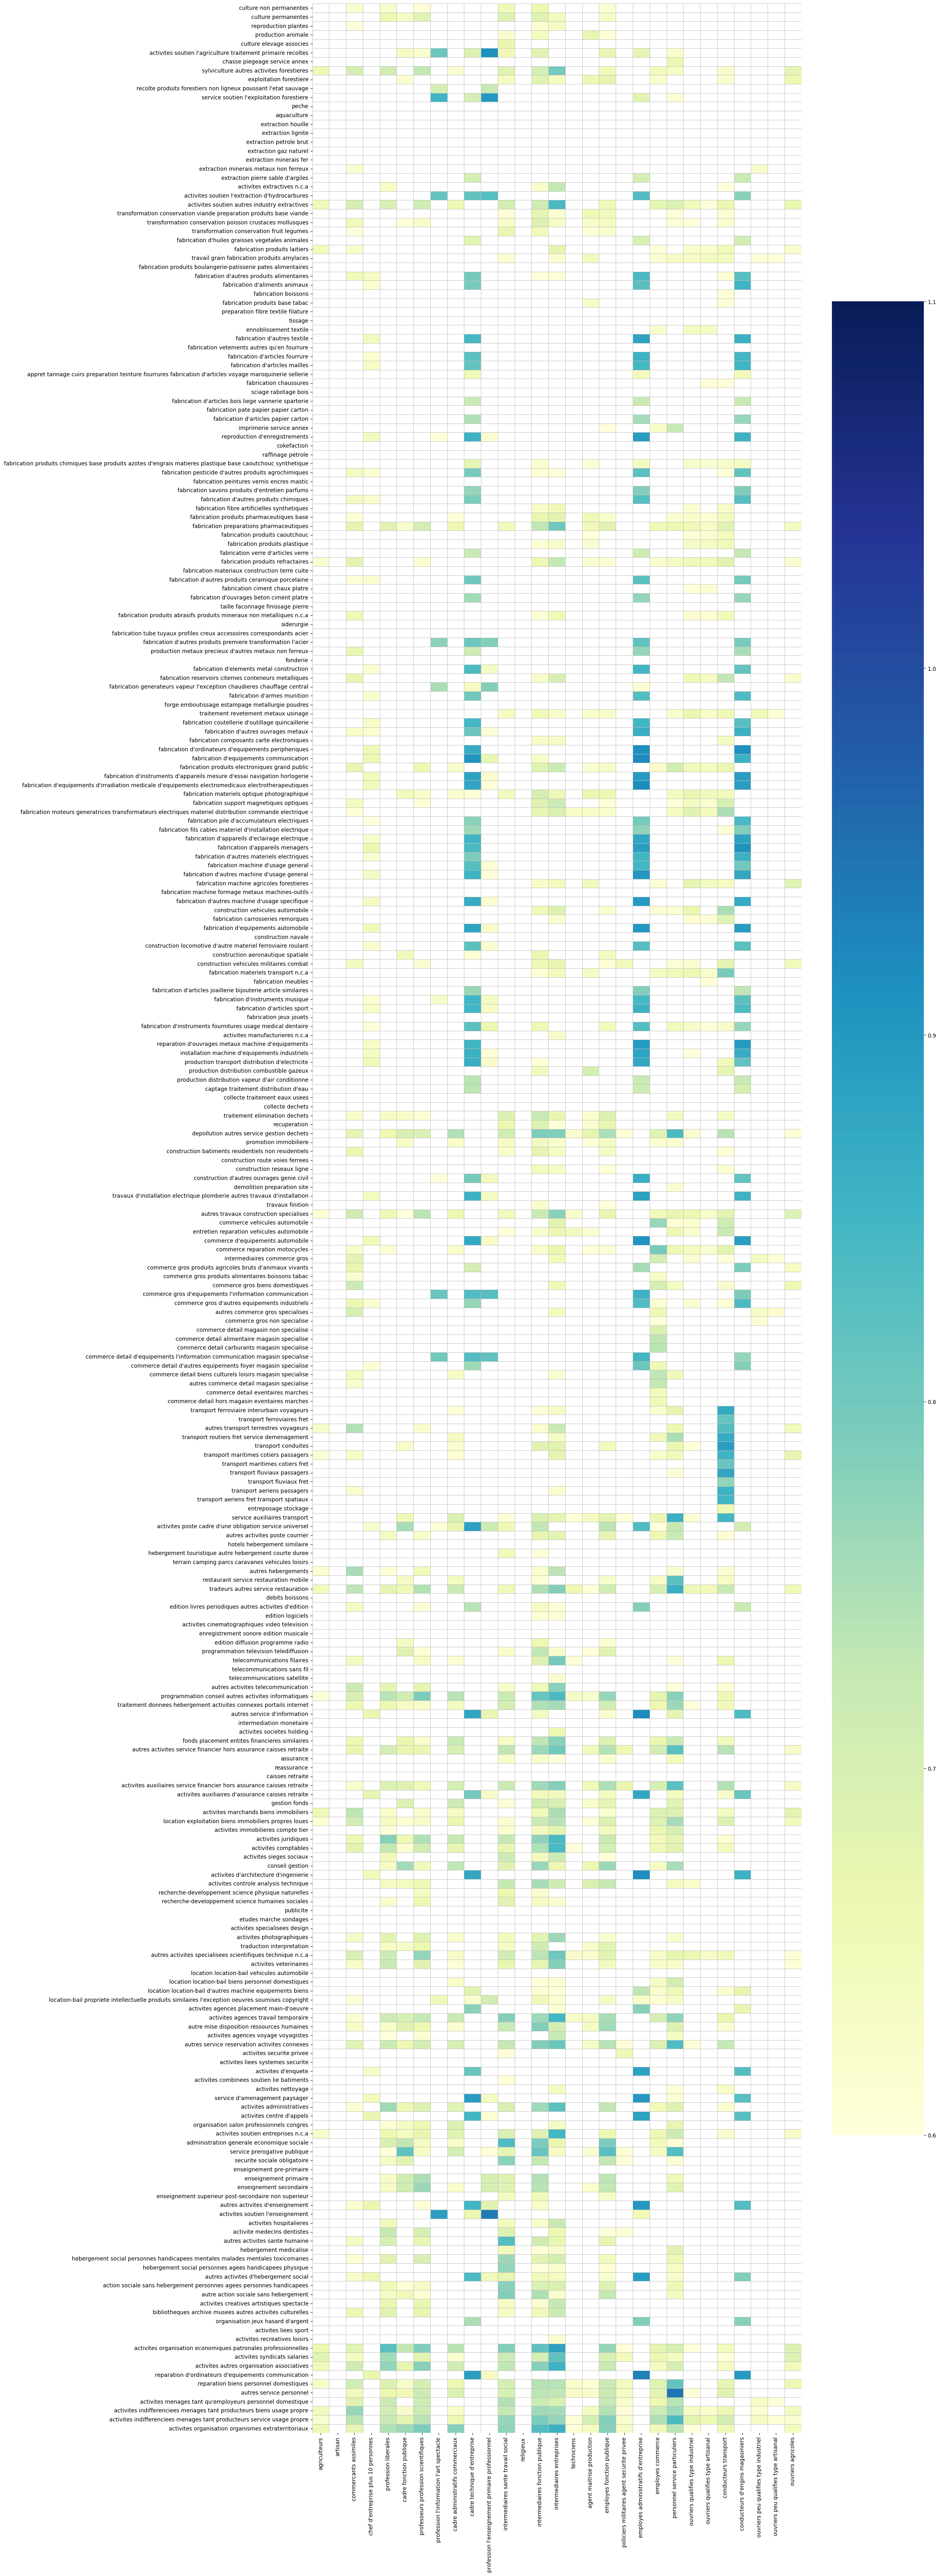

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from copy import copy

%matplotlib inline

fig, ax = plt.subplots(figsize=(20,80))     

#conditions for filtering 0.6<=r<=0.9
val_min = 0.6
val_max = 1.1

my_cmap = copy(plt.cm.YlGnBu)
my_cmap.set_over("white")
my_cmap.set_under("white")

sns.heatmap(df,
            annot=False,
            linewidths=.5,
            linecolor="silver",
            ax=ax,
            vmin=val_min,
            vmax=val_max,
            cmap=my_cmap,)